In [1]:
# Step 1: Import libraries and load data
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend
from keras.layers import Dropout
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Download stock data for Microsoft (ticker symbol: MSFT) from Yahoo Finance
msft = pd.read_csv("C:/Users/adeye/Downloads/MSFT.csv")

In [3]:
# Download gold data for gold (ticker symbol: GC=F) from Yahoo Finance
gold = pd.read_csv("C:/Users/adeye/Downloads/Gold.csv")

In [4]:
inflation = pd.read_csv("C:/Users/adeye/OneDrive/Desktop/BLS Inflation data time series.csv")

In [5]:
unemployment = pd.read_csv("C:/Users/adeye/OneDrive//Desktop/BLS Unemployment rate time series.csv")

In [6]:
merged_df = msft.copy()
merged_df = pd.merge(merged_df, inflation[['Date', 'Inflation']], on='Date', how='left')
merged_df = pd.merge(merged_df, gold[['Date', 'Close/Last']], on='Date', how='left')
merged_df = pd.merge(merged_df, unemployment[['Date', 'Unemployment']], on='Date', how='left')
df = merged_df

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
0,1/2/2013,27.250000,27.730000,27.150000,27.620001,22.72,52899300,0.2,NaN,8.0
1,1/3/2013,27.629999,27.650000,27.160000,27.250000,22.41,48294400,0.2,NaN,8.0
2,1/4/2013,27.270000,27.340000,26.730000,26.740000,21.99,52521100,0.2,NaN,8.0
3,1/7/2013,26.770000,26.879999,26.639999,26.690001,21.95,37110400,0.2,NaN,8.0
4,1/8/2013,26.750000,26.790001,26.459999,26.549999,21.84,44703100,0.2,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...
2570,3/20/2023,276.980011,277.480011,269.850006,272.230011,272.23,43466600,NaN,1999.7,NaN
2571,3/21/2023,274.880005,275.000000,269.519989,273.779999,273.78,34558700,NaN,1941.1,NaN
2572,3/22/2023,273.399994,281.040009,272.179993,272.290009,272.29,34873300,NaN,1949.6,NaN
2573,3/23/2023,277.940002,281.059998,275.200012,277.660004,277.66,36610900,NaN,1995.9,NaN


In [8]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
0,1/2/2013,27.250000,27.730000,27.150000,27.620001,22.72,52899300,0.2,NaN,8.0
1,1/3/2013,27.629999,27.650000,27.160000,27.250000,22.41,48294400,0.2,NaN,8.0
2,1/4/2013,27.270000,27.340000,26.730000,26.740000,21.99,52521100,0.2,NaN,8.0
3,1/7/2013,26.770000,26.879999,26.639999,26.690001,21.95,37110400,0.2,NaN,8.0
4,1/8/2013,26.750000,26.790001,26.459999,26.549999,21.84,44703100,0.2,NaN,8.0
5,1/9/2013,26.719999,26.750000,26.559999,26.700001,21.96,49047900,0.2,NaN,8.0
6,1/10/2013,26.650000,26.980000,26.290001,26.459999,21.76,71431300,0.2,NaN,8.0
7,1/11/2013,26.490000,26.930000,26.280001,26.830000,22.07,55512100,0.2,NaN,8.0
8,1/14/2013,26.900000,27.080000,26.760000,26.889999,22.12,48324400,0.2,NaN,8.0
9,1/15/2013,26.830000,27.290001,26.830000,27.209999,22.38,48244500,0.2,NaN,8.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2575 entries, 0 to 2574
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2575 non-null   object 
 1   Open          2575 non-null   float64
 2   High          2575 non-null   float64
 3   Low           2575 non-null   float64
 4   Close         2575 non-null   float64
 5   Adj Close     2575 non-null   float64
 6   Volume        2575 non-null   int64  
 7   Inflation     2557 non-null   float64
 8   Close/Last    2518 non-null   float64
 9   Unemployment  2557 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 221.3+ KB


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
count,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2.575000e+03,2557.000000,2518.000000,2557.000000
mean,124.674054,125.936128,123.369565,124.717953,120.020730,3.227252e+07,0.207939,1446.053177,5.254752
std,90.942821,91.957887,89.867191,90.956959,91.853274,1.670179e+07,0.268588,264.827419,1.810415
min,26.490000,26.750000,26.280001,26.459999,21.760000,7.425600e+06,-0.800000,1049.600000,3.400000
25%,47.254999,47.695000,46.710001,47.299999,41.485000,2.248075e+07,0.100000,1244.225000,3.900000
50%,90.610001,92.459999,89.660004,91.269997,85.790000,2.837280e+07,0.200000,1319.100000,4.900000
75%,209.574997,212.040001,207.244996,209.764999,205.010000,3.673285e+07,0.300000,1734.600000,6.100000
max,344.619995,349.670013,342.200012,343.109985,339.080000,2.484285e+08,1.200000,2069.400000,14.700000


In [11]:
df.isnull().sum()

Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Inflation       18
Close/Last      57
Unemployment    18
dtype: int64

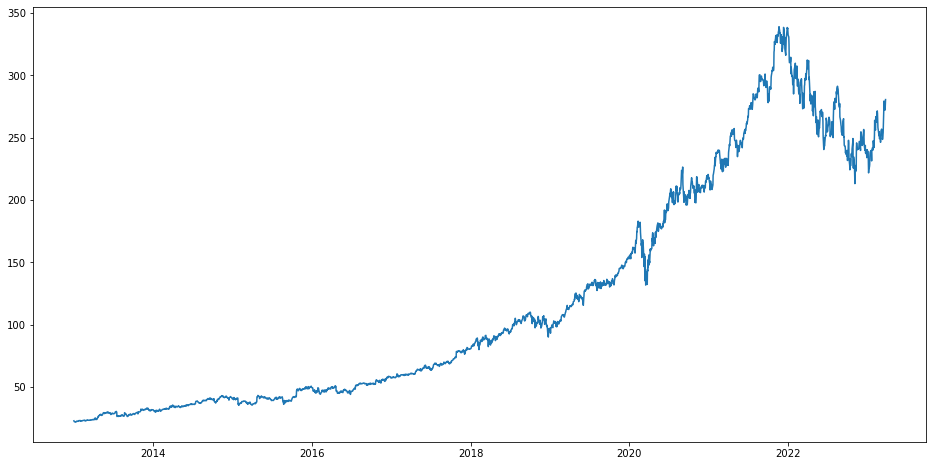

In [12]:
df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%Y")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Adj Close"],label='Close Price history')

In [13]:
from sklearn.impute import KNNImputer

In [14]:
n_neighbors = 5

# create a k-NN imputer object
imputer = KNNImputer(n_neighbors=n_neighbors)

# loop over each column in the DataFrame
for column in df.columns:
    # get the column data as a numpy array
    column_data = df[column].values.reshape(-1, 1)
    
    # use k-NN imputation to fill in missing values
    imputer.fit(column_data)
    column_data_imputed = imputer.transform(column_data)
    
    # replace the original column with the imputed column
    df[column] = column_data_imputed.flatten()

print(df)

                    Date        Open        High         Low       Close  \
Date                                                                       
2013-01-02  1.357085e+18   27.250000   27.730000   27.150000   27.620001   
2013-01-03  1.357171e+18   27.629999   27.650000   27.160000   27.250000   
2013-01-04  1.357258e+18   27.270000   27.340000   26.730000   26.740000   
2013-01-07  1.357517e+18   26.770000   26.879999   26.639999   26.690001   
2013-01-08  1.357603e+18   26.750000   26.790001   26.459999   26.549999   
...                  ...         ...         ...         ...         ...   
2023-03-20  1.679270e+18  276.980011  277.480011  269.850006  272.230011   
2023-03-21  1.679357e+18  274.880005  275.000000  269.519989  273.779999   
2023-03-22  1.679443e+18  273.399994  281.040009  272.179993  272.290009   
2023-03-23  1.679530e+18  277.940002  281.059998  275.200012  277.660004   
2023-03-24  1.679616e+18  277.239990  280.630005  275.279999  280.570007   

           

In [15]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
Date,,,,,,,,,,
2013-01-02,1.357085e+18,27.250000,27.730000,27.150000,27.620001,22.72,52899300.0,0.2,1446.053177,8.0
2013-01-03,1.357171e+18,27.629999,27.650000,27.160000,27.250000,22.41,48294400.0,0.2,1446.053177,8.0
2013-01-04,1.357258e+18,27.270000,27.340000,26.730000,26.740000,21.99,52521100.0,0.2,1446.053177,8.0
2013-01-07,1.357517e+18,26.770000,26.879999,26.639999,26.690001,21.95,37110400.0,0.2,1446.053177,8.0
2013-01-08,1.357603e+18,26.750000,26.790001,26.459999,26.549999,21.84,44703100.0,0.2,1446.053177,8.0


In [16]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Inflation       0
Close/Last      0
Unemployment    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2013-01-02 to 2023-03-24
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2575 non-null   float64
 1   Open          2575 non-null   float64
 2   High          2575 non-null   float64
 3   Low           2575 non-null   float64
 4   Close         2575 non-null   float64
 5   Adj Close     2575 non-null   float64
 6   Volume        2575 non-null   float64
 7   Inflation     2575 non-null   float64
 8   Close/Last    2575 non-null   float64
 9   Unemployment  2575 non-null   float64
dtypes: float64(10)
memory usage: 221.3 KB


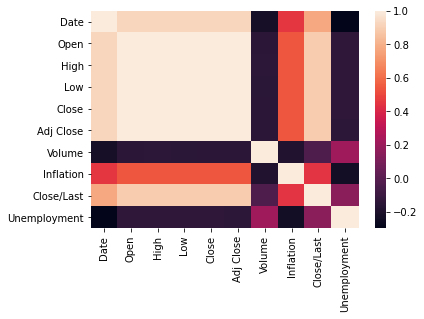

In [18]:
_ = sns.heatmap(df.corr())

In [19]:
Cleansed_df = df.drop(['Date', 'Volume', 'Open', 'Close', 'High', 'Low', 'Unemployment'], axis=1)

In [20]:
Cleansed_df.rename(columns = {'Close/Last':'Gold Price', 'Inflation':'Inflation Rate', 'Adj Close':'MSFT Stock Price'}, inplace = True)

In [21]:
Cleansed_df.head()

,MSFT Stock Price,Inflation Rate,Gold Price
Date,,,
2013-01-02,22.72,0.2,1446.053177
2013-01-03,22.41,0.2,1446.053177
2013-01-04,21.99,0.2,1446.053177
2013-01-07,21.95,0.2,1446.053177
2013-01-08,21.84,0.2,1446.053177


In [22]:
Cleansed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2013-01-02 to 2023-03-24
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSFT Stock Price  2575 non-null   float64
 1   Inflation Rate    2575 non-null   float64
 2   Gold Price        2575 non-null   float64
dtypes: float64(3)
memory usage: 80.5 KB


In [23]:
Cleansed_df.shape

(2575, 3)

We have 3 feature columns and one target column. The target column is 'Adj Close' and there are 2543 rows to the data frame.¶

EDA for the data set

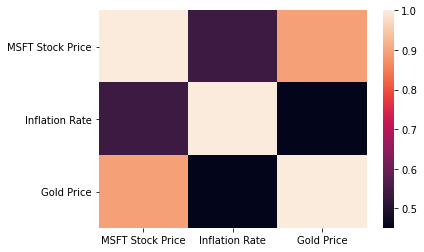

In [24]:
_ = sns.heatmap(Cleansed_df.corr())

In [25]:
# features creation by making it into a function

def create_features(Cleansed_df):
    """
    Create time series features based on time series index
    """
    Cleansed_df = Cleansed_df.copy()
    Cleansed_df['day of week'] = Cleansed_df.index.dayofweek
    Cleansed_df['quarter'] = Cleansed_df.index.quarter
    Cleansed_df['month'] = Cleansed_df.index.month
    Cleansed_df['year'] = Cleansed_df.index.year
    return Cleansed_df

Cleansed_df = create_features(Cleansed_df)

<AxesSubplot:xlabel='month', ylabel='MSFT Stock Price'>

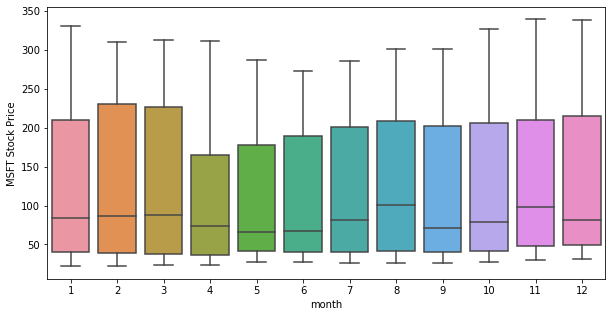

In [26]:
# We could vitualize our features

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='month', y='MSFT Stock Price')

<AxesSubplot:xlabel='quarter', ylabel='MSFT Stock Price'>

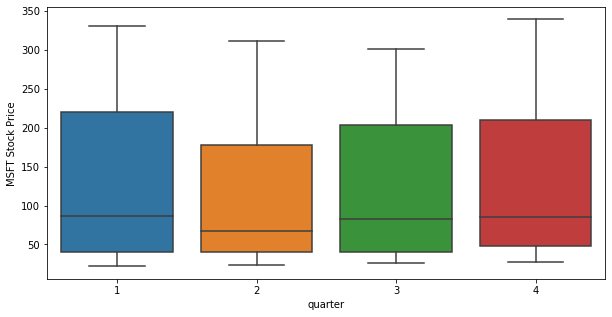

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='quarter', y='MSFT Stock Price')

<AxesSubplot:xlabel='year', ylabel='MSFT Stock Price'>

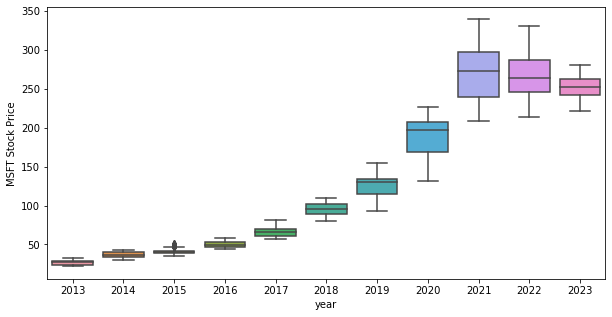

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='year', y='MSFT Stock Price')

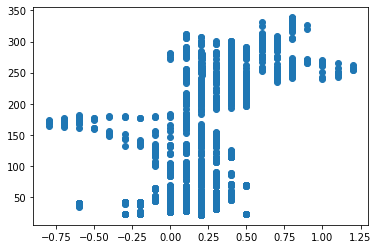

In [29]:
plt.scatter(Cleansed_df['Inflation Rate'],Cleansed_df['MSFT Stock Price'])

In [30]:
# Select relevant columns for analysis
Cleansed_df = Cleansed_df[['MSFT Stock Price', 'Inflation Rate', 'Gold Price']]

In [31]:
# Define helper functions to create the dataset for the LSTM model
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps, 1:])
        y.append(data[i+time_steps, 0])
    X, y = np.array(X), np.array(y)
    return X, y

# Set the time steps parameter
time_steps = 60

In [32]:
# Split the data into train, validation, and test sets
train_size = int(len(Cleansed_df) * 0.7)
val_size = int(len(Cleansed_df) * 0.1)
test_size = len(Cleansed_df) - train_size - val_size

train_data = Cleansed_df.iloc[:train_size, :]
val_data = Cleansed_df.iloc[train_size:train_size+val_size, :]
test_data = Cleansed_df.iloc[train_size+val_size:, :]

In [33]:
# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

In [34]:
# Create the training, validation, and test datasets
X_train, y_train = create_dataset(train_data, time_steps)
X_val, y_val = create_dataset(val_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [35]:
X_train.shape

(1742, 60, 2)

In [36]:
y_train.shape

(1742,)

In [37]:
# Define and train the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))


Epoch 1/10
291/291 [==============================] - 4s 11ms/step - loss: 0.0401 - val_loss: 0.0346
Epoch 2/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0334 - val_loss: 1.3656
Epoch 3/10
291/291 [==============================] - 3s 11ms/step - loss: 0.0294 - val_loss: 0.5839
Epoch 4/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0305 - val_loss: 0.3001
Epoch 5/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0276 - val_loss: 0.0943
Epoch 6/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0317 - val_loss: 0.2467
Epoch 7/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0272 - val_loss: 0.3685
Epoch 8/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0277 - val_loss: 0.1898
Epoch 9/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0260 - val_loss: 0.4411
Epoch 10/10
291/291 [==============================] - 3s 10ms/step - loss: 0.0248 - val_lo

In [38]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

Train loss: 0.023668747395277023
Validation loss: 0.44214823842048645
Test loss: 0.15067097544670105


In [39]:
# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

15/15 [==============================] - 0s 5ms/step


In [40]:
# y_train_pred_reshaped = y_train_pred.reshape(-1, 1)

In [41]:
y_train_pred_inverse = scaler.inverse_transform(np.concatenate((y_train_pred, X_train[:, 0, :]), axis=1))[:, 0]
y_val_pred_inverse = scaler.inverse_transform(np.concatenate((y_val_pred, X_val[:, 0, :]), axis=1))[:, 0]
y_test_pred_inverse = scaler.inverse_transform(np.concatenate((y_test_pred, X_test[:, 0, :]), axis=1))[:, 0]

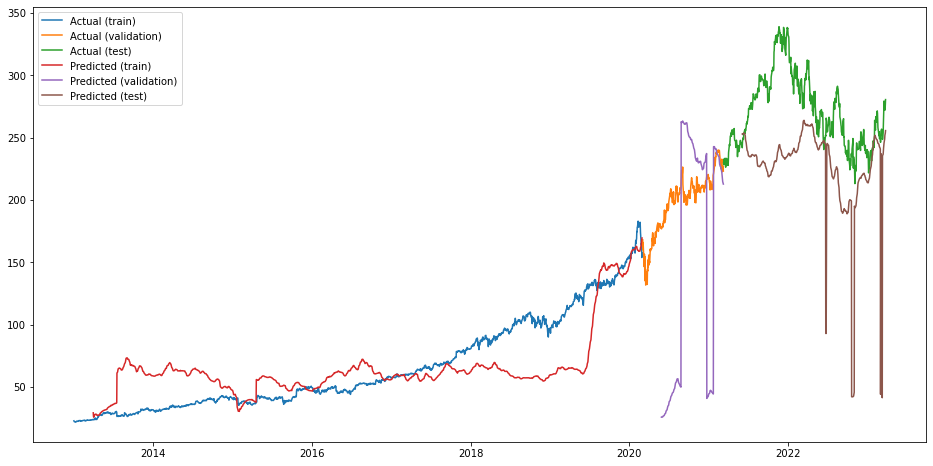

In [42]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

In [43]:
history.history

{'loss': [0.040131937712430954,
  0.033413808792829514,
  0.029400084167718887,
  0.03054281324148178,
  0.027602436020970345,
  0.031737834215164185,
  0.027196185663342476,
  0.027727406471967697,
  0.026022227481007576,
  0.024788888171315193],
 'val_loss': [0.034585874527692795,
  1.365592122077942,
  0.5839080810546875,
  0.3000655770301819,
  0.09433969110250473,
  0.24669583141803741,
  0.36854371428489685,
  0.18983395397663116,
  0.4410678744316101,
  0.44214820861816406]}

<AxesSubplot:>

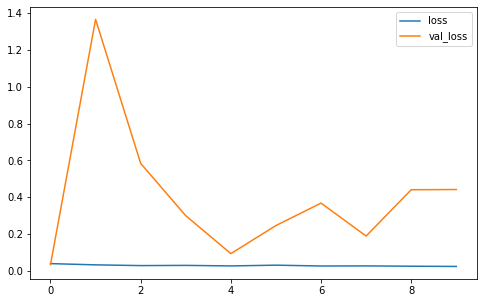

In [44]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [45]:
X_train.shape

(1742, 60, 2)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
15/15 [==============================] - 0s 19ms/step - loss: 0.2299
Train loss: 0.0257182065397501
Validation loss: 0.6037020087242126
Test loss: 0.22985349595546722
15/15 [==============================] - 0s 18ms/step


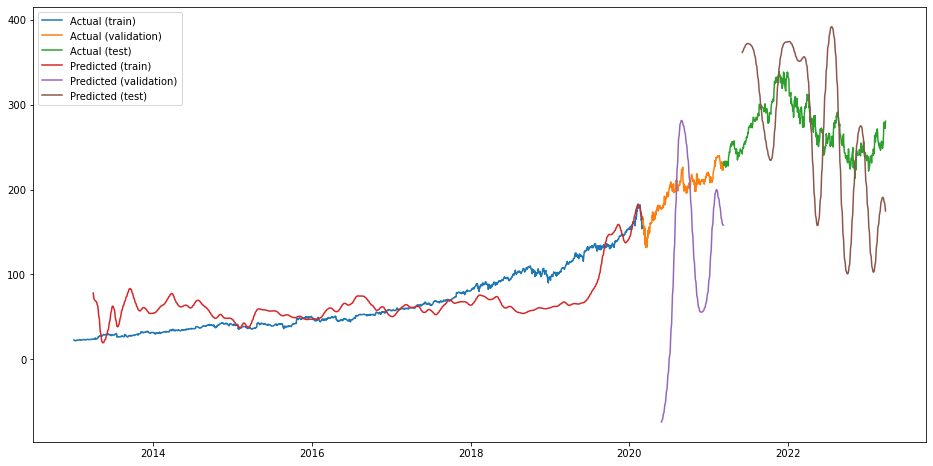

In [46]:
backend.clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.0001

# Compiling the RNN
model.compile(loss='mse', optimizer=Adam(lr=lr))

history = model.fit(X_train, y_train, epochs=15, batch_size=10, validation_data=(X_val, y_val), verbose=3)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = scaler.inverse_transform(np.concatenate((y_train_pred, X_train[:, 0, :]), axis=1))[:, 0]
y_val_pred_inverse = scaler.inverse_transform(np.concatenate((y_val_pred, X_val[:, 0, :]), axis=1))[:, 0]
y_test_pred_inverse = scaler.inverse_transform(np.concatenate((y_test_pred, X_test[:, 0, :]), axis=1))[:, 0]

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

Epoch 1/20
349/349 [==============================] - 20s 48ms/step - loss: 0.0428 - val_loss: 0.0953
Epoch 2/20
349/349 [==============================] - 17s 48ms/step - loss: 0.0351 - val_loss: 0.4662
Epoch 3/20
349/349 [==============================] - 17s 48ms/step - loss: 0.0339 - val_loss: 0.2452
Epoch 4/20
349/349 [==============================] - 17s 48ms/step - loss: 0.0321 - val_loss: 0.0439
Epoch 5/20
349/349 [==============================] - 17s 50ms/step - loss: 0.0331 - val_loss: 0.1242
Epoch 6/20
349/349 [==============================] - 18s 52ms/step - loss: 0.0302 - val_loss: 0.4023
Epoch 7/20
349/349 [==============================] - 21s 60ms/step - loss: 0.0305 - val_loss: 0.1411
Epoch 8/20
349/349 [==============================] - 19s 54ms/step - loss: 0.0357 - val_loss: 0.0714
Epoch 9/20
349/349 [==============================] - 21s 60ms/step - loss: 0.0316 - val_loss: 0.1739
Epoch 10/20
349/349 [==============================] - 21s 61ms/step - loss: 0.029

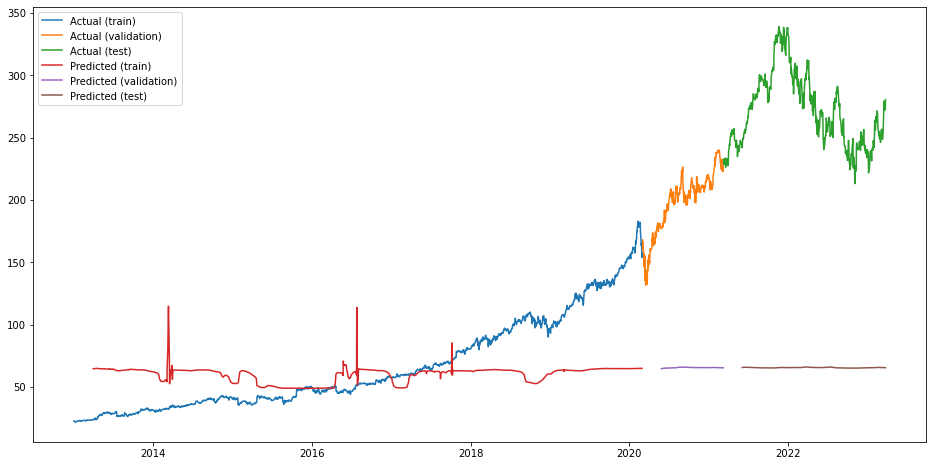

<AxesSubplot:>

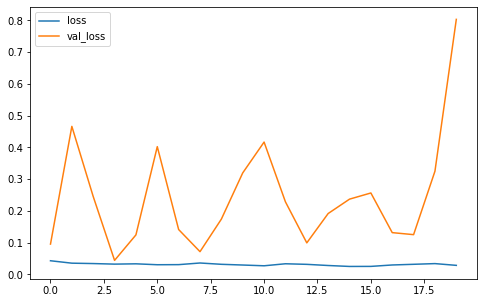

In [47]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.001

# Compiling the RNN
model.compile(loss='mse', optimizer=Adam(lr=lr))

history = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = scaler.inverse_transform(np.concatenate((y_train_pred, X_train[:, 0, :]), axis=1))[:, 0]
y_val_pred_inverse = scaler.inverse_transform(np.concatenate((y_val_pred, X_val[:, 0, :]), axis=1))[:, 0]
y_test_pred_inverse = scaler.inverse_transform(np.concatenate((y_test_pred, X_test[:, 0, :]), axis=1))[:, 0]

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

pd.DataFrame(history.history).plot(figsize=(8,5))

# Using xgboost in prediction

In [48]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [51]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [52]:
backend.clear_session()
# Train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.7,
    missing=-999,
    random_state=42,
    tree_method='gpu_hist')

xgb_model.fit(X_train, y_train,
             eval_set = [(X_val, y_val)],
            verbose=100)

[0]	validation_0-rmse:0.65921
[100]	validation_0-rmse:0.45419
[200]	validation_0-rmse:0.44784
[300]	validation_0-rmse:0.44666
[400]	validation_0-rmse:0.44702
[500]	validation_0-rmse:0.44704
[600]	validation_0-rmse:0.44707
[700]	validation_0-rmse:0.44706
[800]	validation_0-rmse:0.44706
[900]	validation_0-rmse:0.44705
[999]	validation_0-rmse:0.44706


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=-999, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [53]:
y_train_pred_1 = xgb_model.predict(X_train)
y_val_pred_1 = xgb_model.predict(X_val)
y_test_pred_1 = xgb_model.predict(X_test)

In [54]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_test_pred_1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.6940000920337348


In [56]:
print(y_train_pred_1.shape)
print(y_val_pred_1.shape)
print(y_test_pred_1.shape)

(1742,)
(197,)
(456,)


In [55]:
y_train_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_train_pred_1.reshape(-1, 1), X_train[:, :1, :]), axis=1))[:, 0]
y_val_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_val_pred_1.reshape(-1, 1), X_val[:, :1, :]), axis=1))[:, 0]
y_test_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_test_pred_1.reshape(-1, 1), X_test[:, :1, :]), axis=1))[:, 0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [57]:
y_train_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_train_pred_1.reshape(-1, 1), X_train[:, :1, :]), axis=1))[:, 0]
y_val_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_val_pred_1.reshape(-1, 1), X_val[:, :1, :]), axis=1))[:, 0]
y_test_pred_inverse_xgb = scaler.inverse_transform(np.concatenate((y_test_pred_1.reshape(-1, 1), X_test[:, :1, :]), axis=1))[:, 0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Plot the actual and predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred_1, label='Predicted')
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse_xgb, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse_xgb, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse_xgb, label='Predicted (test)')

plt.legend()
plt.show()

# using RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
backend.clear_session()

rf = RandomForestRegressor(n_estimators=10,random_state=0)
rf.fit(X_train, y_train)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

In [ ]:
#prediction the test set result
y_train_pred_2 = rf.predict(X_train)
y_val_pred_2 = rf.predict(X_val)
y_test_pred_2 = rf.predict(X_test)

In [ ]:
y_train_pred_inverse_rf = scaler.inverse_transform(np.concatenate((y_train_pred_2, X_train[:, 0, :]), axis=1))[:, 0]
y_val_pred_inverse_rf = scaler.inverse_transform(np.concatenate((y_val_pred_2, X_val[:, 0, :]), axis=1))[:, 0]
y_test_pred_inverse_rf = scaler.inverse_transform(np.concatenate((y_test_pred_2, X_test[:, 0, :]), axis=1))[:, 0]

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse_rf, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse_rf, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse_rf, label='Predicted (test)')

plt.legend()
plt.show()

# Using SVC

In [ ]:
from sklearn.svm import SVR

In [ ]:
backend.clear_session()

svr_model = SVR(kernel='rbf', epsilon=0.1)
svr_model.fit(X_train,y_train)

In [ ]:
#prediction the test set result
y_train_pred_3 = svr_model.predict(X_train)
y_val_pred_3 = svr_model.predict(X_val)
y_test_pred_3 = svr_model.predict(X_test)

In [ ]:
y_train_pred_inverse_svr = scaler.inverse_transform(np.concatenate((y_train_pred_3, X_train[:, 0, :]), axis=1))[:, 0]
y_val_pred_inverse_svr = scaler.inverse_transform(np.concatenate((y_val_pred_3, X_val[:, 0, :]), axis=1))[:, 0]
y_test_pred_inverse_svr = scaler.inverse_transform(np.concatenate((y_test_pred_3, X_test[:, 0, :]), axis=1))[:, 0]

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse_svr, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse_svr, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse_svr, label='Predicted (test)')

plt.legend()
plt.show()